In [62]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from movie_sentiment.processing.arcs import get_all_reshaped_arcs
from movie_sentiment.params import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Standardize arcs and preparing df

In [40]:
arcs = get_all_reshaped_arcs(dyn_avg=True)

Loading data from pickle file


2 following cells are optional (for standardization of the data)

In [41]:
X = arcs.drop(columns='movie_name')

s_scaler = StandardScaler()
s_scaler.fit(X.T)
scaled = s_scaler.transform(X.T)
X_scaled = pd.DataFrame(scaled.T, columns=X.columns)

In [42]:
columns_ids = [i for i in range(30)]

for i in columns_ids:
    arcs[i] = X_scaled[i]

In [43]:
df_reco_1 = arcs.set_index('movie_name')

In [44]:
df_reco_1.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
movie_name,,,,,,,,,,,,,,,,,,,,,
Fernando Arrabal lit Sa corolle noire ditions A Biren suivi de Ah la belle ann e ditions Ginasservis et Paris,-1.598291,-1.778773,-1.374239,-1.363652,-1.355981,-0.459759,-0.017918,-0.202872,-1.024959,-0.841603,...,1.156356,0.726309,0.116753,-0.662530,-0.368297,-0.362491,-0.242547,0.316914,0.827208,2.184837
It s Kind of a Funny Story,-0.169236,0.593324,1.101164,0.903140,0.965396,0.531421,-0.038163,-0.467987,-0.723052,-0.379225,...,-1.139889,-1.281726,-0.913743,-0.544836,-0.582910,0.173852,0.451509,1.561008,2.286078,0.780361
Neither Seen Nor Recognized,0.127829,0.414927,-0.111587,0.117459,0.435570,0.960243,1.671093,1.368567,1.008647,0.482891,...,-0.914588,-1.498294,-1.752695,-2.210531,-2.025708,-1.432724,-0.888310,0.099751,1.494704,-0.419205


### Find similar movies based on arcs

In [45]:
movie_ex = np.array(df_reco_1.loc['Up']).reshape(1, -1)
similarity_score = cosine_similarity(df_reco_1, movie_ex)

In [46]:
recommendation_df = pd.DataFrame(similarity_score, index = df_reco_1.index)
recommendation_df.sort_values(0, ascending=False, inplace=True)
recommendation_df.head(6)

,0
movie_name,
Up,1.000000
Tarzan s Secret Treasure,0.915319
Limbo,0.900012
Pain and Glory,0.865722
Good Boy,0.863963
Snatch,0.862364


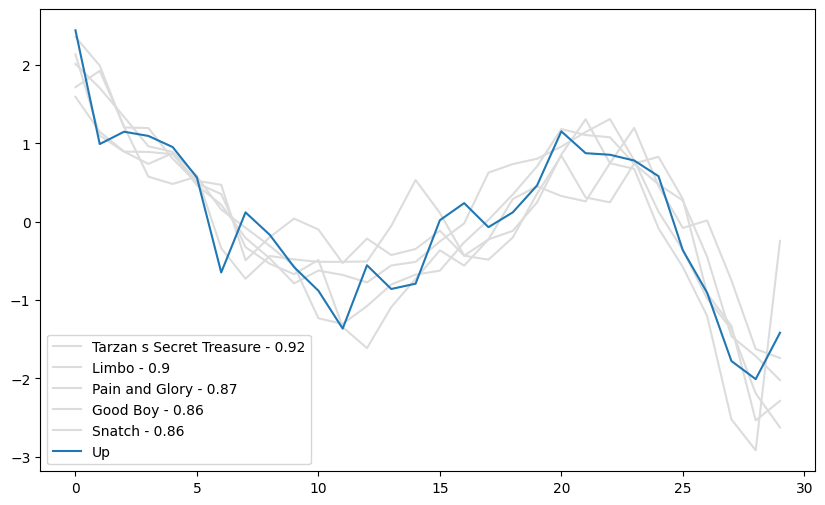

In [9]:
plt.figure(figsize=(10,6))
for row in recommendation_df.iloc[1:6].iterrows():
    id = row[0]
    score = round(row[1][0],2)
    plt.plot(df_reco_1.loc[id], color='gainsboro', label=f"{id} - {score}")

plt.plot(df_reco_1.loc['Up'], label='Up')
plt.legend()

### Get movies metadata

Get data

In [120]:
movie_meta = pd.read_csv('./raw_data/movie_metadata/movie_meta_data.csv')
movie_meta.columns

Index(['imdbid', 'title', 'akas', 'year', 'metascore', 'imdb user rating',
       'number of imdb user votes', 'awards', 'opening weekend', 'producers',
       'budget', 'script department', 'production companies', 'writers',
       'directors', 'casting directors', 'cast', 'countries', 'age restrict',
       'plot', 'plot outline', 'keywords', 'genres', 'taglines', 'synopsis'],
      dtype='object')

In [121]:
movie_meta = movie_meta[['imdbid','title', 'keywords', 'genres']]

In [122]:
movie_meta.head()

,imdbid,title,keywords,genres
0,120770,A Night at the Roxbury,"woman-on-top, nightclub, car-accident, 1990s, ...","Comedy, Music, Romance"
1,132512,At First Sight,"visual-agnosia, brother-sister-relationship, r...","Drama, Romance"
2,118661,The Avengers,"good-versus-evil, heroine, evil-man, villain, ...","Action, Adventure, Sci-Fi, Thriller"
3,215545,Bamboozled,"television-industry, african-american, referen...","Comedy, Drama, Music"
4,118715,The Big Lebowski,"rug, nihilism, pornographer, bowling-alley, de...","Comedy, Crime, Sport"


Compute and clean meta data

In [123]:
movie_meta['meta'] = movie_meta['genres'] + ', ' + movie_meta['keywords']

In [124]:
movie_meta['meta'] = movie_meta['meta'].str.replace(',', '')

In [125]:
movie_meta['meta'] = movie_meta['meta'].fillna('')

In [147]:
movie_meta['genres'] = movie_meta['genres'].fillna('')

Convert to vectors

In [148]:
count = CountVectorizer()
count_matrix = count.fit_transform(movie_meta['genres'])
count_df = pd.DataFrame(count_matrix.toarray(), index=movie_meta.index.tolist())

Reduce dimensions

In [152]:
svd = TruncatedSVD(n_components=20)
df_reco_2 = svd.fit_transform(count_df)

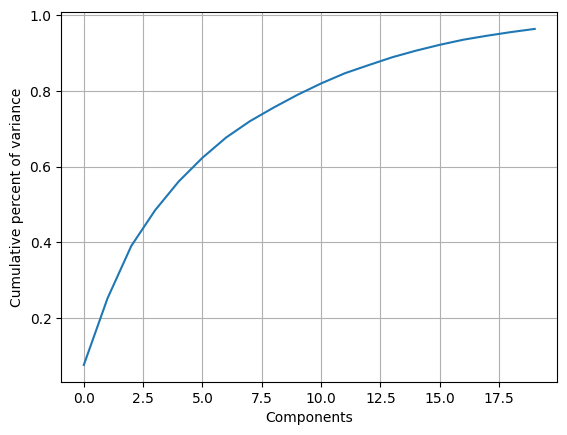

In [153]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('Components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [154]:
df_reco_2 = pd.DataFrame(df_reco_2, index=movie_meta.imdbid.tolist())
df_reco_2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
120770,0.530932,-0.547894,0.842125,0.494829,0.276456,-0.274285,0.583157,0.077572,-0.048016,0.036307,0.248086,0.062595,0.042189,-0.014752,-0.114792,0.404726,0.801440,-0.048564,0.165926,0.021716
132512,0.877430,-0.706023,0.003138,-0.464650,0.093140,-0.020102,0.647241,0.200158,0.108014,-0.027805,-0.022893,-0.141331,-0.000999,0.084930,-0.022409,-0.000803,-0.043927,-0.041029,-0.020963,-0.010861
118661,1.146052,1.735228,0.379316,-0.322780,-0.159149,-0.278247,0.197216,-0.003353,-0.484903,-0.114983,0.046178,-0.076311,0.076013,-0.131903,-0.069377,0.014906,-0.008335,0.020363,0.005781,-0.005115
215545,0.995355,-0.731454,0.435135,0.097159,0.089485,-0.131118,-0.400729,-0.293141,-0.128696,0.150804,-0.229366,-0.021362,0.040627,-0.034585,-0.163152,0.392453,0.820800,-0.099069,0.123214,0.049527
118715,0.557828,-0.272538,0.375366,0.878542,-0.221757,-0.463716,-0.467925,0.101338,0.321790,-0.082587,0.240813,-0.106218,0.025375,-0.094508,-0.066012,-0.107967,-0.148107,0.356474,0.824663,-0.349727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114924,1.175526,-0.963695,0.614634,0.064563,0.228683,-0.210382,0.430104,0.006806,-0.023963,0.081055,-0.067305,-0.060481,-0.008673,-0.018664,-0.016500,-0.049468,-0.051152,-0.037001,-0.035167,0.005762
3011894,1.355643,-0.375988,-0.019520,0.461598,0.221338,-0.131164,-0.182156,-0.356820,-0.591776,-0.154185,-0.416756,0.133652,-0.011373,-0.092686,-0.042887,-0.041254,-0.013595,-0.010796,-0.034207,0.031285
5362988,1.454185,-0.018894,-1.054420,0.451225,0.045282,0.045145,-0.304922,0.642142,-0.015291,0.222906,0.033290,-0.014388,0.041807,-0.054271,0.024288,0.009734,-0.011960,0.007882,0.008399,-0.012509
120901,0.939724,0.486016,0.278373,0.897338,-0.222054,-0.269220,0.256570,-0.623347,-0.367287,0.224339,-0.237459,0.397715,-0.114315,0.042200,-0.061957,-0.025124,0.000392,-0.005654,-0.028994,0.031122


In [155]:
with open(IDS_PICKLE_FILE, 'rb') as handle:
    ids = pickle.load(handle)

In [156]:
for key, value in ids.items():
    if key in df_reco_2.index:
        df_reco_2.loc[key,'movie_name'] = value

In [157]:
df_reco_2.set_index('movie_name', inplace=True)

In [135]:
df_reco_2.loc['Up']

0      17.246343
1      -6.083397
2      -7.243080
3       1.917978
4      -5.871992
         ...    
195    -0.780250
196     0.785906
197    -1.839639
198    -0.707109
199    -1.121063
Name: Up, Length: 200, dtype: float64

### Find similar movies based on arcs and meta

Compute similarities for a movie

In [181]:
movie_ex = 'Toy Story'
movie_ex1 = np.array(df_reco_1.loc[movie_ex]).reshape(1, -1)
movie_ex2 = np.array(df_reco_2.loc[movie_ex]).reshape(1, -1)

similarity_score1 = cosine_similarity(df_reco_1, movie_ex1)
similarity_score2 = cosine_similarity(df_reco_2, movie_ex2)

Regroup in a DataFrame

In [182]:
scores_df1 = pd.DataFrame(similarity_score1, index = df_reco_1.index)
scores_df1.sort_values(0, ascending=False, inplace=True)
scores_df1.columns = ['arcs']

scores_df2 = pd.DataFrame(similarity_score2, index = df_reco_2.index)
scores_df2.sort_values(0, ascending=False, inplace=True)
scores_df2.columns = ['meta']

In [183]:
scores_df = pd.merge(scores_df1, scores_df2, left_index=True, right_index=True)

Compute a global score and select movies

In [184]:
scores_df['total'] = (scores_df['arcs'] + scores_df['meta']) / 2.0

scores_df.sort_values(by=['total'], ascending=False, inplace=True)

scores_df.drop([movie_ex], inplace=True)

scores_df.head(5)

,arcs,meta,total
movie_name,,,
ParaNorman,0.797503,0.910787,0.854145
Inside Out,0.755115,0.910875,0.832995
Stuart Little 2,0.664165,1.000000,0.832083
Toy Story 2,0.621409,1.000000,0.810704
The Lorax,0.704301,0.913793,0.809047


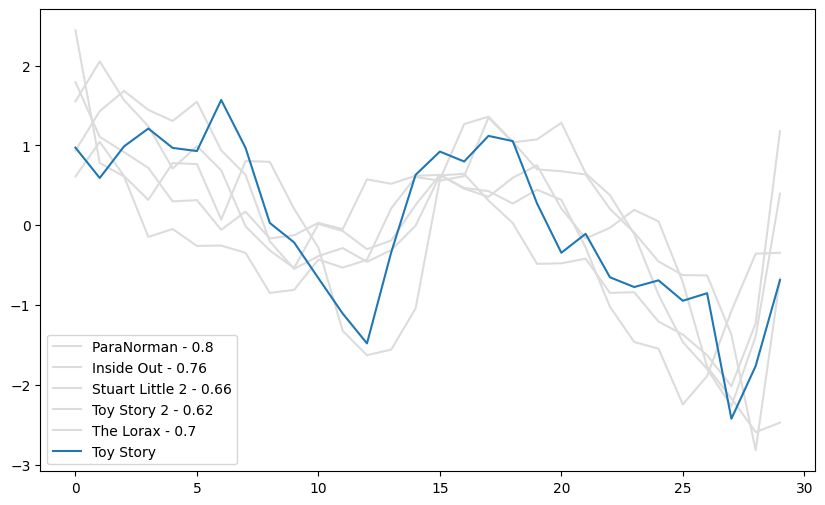

In [185]:
top_5 = []

plt.figure(figsize=(10,6))
for row in scores_df.iloc[0:5].iterrows():
    id = row[0]
    top_5.append(id)
    score = round(row[1][0],2)
    plt.plot(df_reco_1.loc[id], color='gainsboro', label=f"{id} - {score}")

plt.plot(df_reco_1.loc[movie_ex], label=movie_ex)
plt.legend()

In [141]:
top_5

['Toy Story 2',
 'Spider Man 2',
 'Close Encounters of the Third Kind',
 'Collateral',
 'The Shining']

In [145]:
movie_meta[movie_meta['title'] == 'Toy Story']

,imdbid,title,keywords,genres,meta
2424,114709,Toy Story,"toy, rivalry, cowboy, cgi-animation, claw-cran...","Animation, Adventure, Comedy, Family, Fantasy",Animation Adventure Comedy Family Fantasy toy ...


In [143]:
movie_meta[movie_meta['title'] == 'The Shining']

,imdbid,title,keywords,genres,meta
2385,81505,The Shining,"haunted-hotel, labyrinth, identical-twins, hot...","Drama, Horror",Drama Horror haunted-hotel labyrinth identical...


### Test the function

In [25]:
%load_ext autoreload
%autoreload 2

from movie_sentiment.ml_logic.recommendation import get_movies_recommendation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
get_movies_recommendation('Up', n=5)

Loading data from pickle file
Loading metadata from pickle file


{'movie_names': ['Stuart Little 2',
  'Toy Story 2',
  'Inside Out',
  'Curse of the Cat People Glenda and Odessa',
  'How to Train Your Dragon'],
 'movie_scores': [0.81, 0.77, 0.76, 0.75, 0.75]}

### Polynomials

In [27]:
from movie_sentiment.processing.arcs import get_all_polynomials

In [28]:
arcs = get_all_polynomials()

Loading data from pickle file


In [29]:
df_poly = arcs.set_index('movie_name')

In [30]:
movie_ex = np.array(df_poly.loc['Up']).reshape(1, -1)
similarity_score = cosine_similarity(df_poly, movie_ex)

In [31]:
recommendation_df = pd.DataFrame(similarity_score, index = df_poly.index)
recommendation_df.sort_values(0, ascending=False, inplace=True)
recommendation_df.head(6)

,0
movie_name,
Up,1.0
The Great Outdoors,1.0
The Insider,1.0
Star Trek III The Search for Spock,1.0
A Few Good Men,1.0
The Rage Carrie 2,1.0


Plotting polynomials

In [32]:
# x_fit = np.arange(30)
# y_fit = np.polyval(coefficients, x_fit)
# plt.plot(x_fit, y_fit, 'r')


for row in recommendation_df.head(10).iterrows():
    id = row[0]
    if id !=0:
        print(df_poly.loc[id])
        y_fit = np.polyval(df_poly.loc[id], x_fit)
        plt.plot(x_fit, y_fit, color='gainsboro')
        
plt.plot(df_reco_1.loc[id])

0     0.000000e+00
1     0.000000e+00
2     0.000000e+00
3     0.000000e+00
4     0.000000e+00
5     0.000000e+00
6     3.278383e-09
7    -1.626563e-06
8     2.526939e-04
9    -1.316647e-02
10    3.241072e-01
Name: Up, dtype: float64


NameError: name 'x_fit' is not defined

Plotting curves

In [ ]:
for row in recommendation_df.head(10).iterrows():
    id = row[0]
    if id !=0:
        plt.plot(df_reco_1.loc[id], color='gainsboro')
        
plt.plot(df_reco_1.loc[id])